In [1]:
import glob
import re
import pandas as pd
json_files = ['AFR.json', 'AKR.json', 'BRO.json', 'DBL.json', 'DMU.json', 'DOM.json', 'ELD.json', 'IKO.json', 'KHM.json', 'WAR.json', 
              'KLR.json', 'KTK.json', 'LCI.json', 'LTR.json', 'M19.json', 'MAT.json', 'MID.json', 'MKM.json', 'MOM.json', 'NEO.json', 
              'ONE.json', 'RIX.json', 'RNA.json', 'SIR.json', 'SNC.json', 'STX.json', 'THB.json', 'VOW.json', 'WOE.json', 'STA.json', 
              'SIS.json', 'M20.json', 'GRN.json', 'M21.json', 'MUL.json', 'WOT.json', 'SPG.json', 'BRR.json', 'MOC.json']
def clean_card_text(text, name):
    cleaned_text = re.sub(r'\([^)]*\)', '', text)
    cleaned_text = cleaned_text.replace('\n', ' || ')
    if name:
        if '//' in name:
            names = name.split(' // ')
            for split_name in names:
                if split_name in cleaned_text:
                    cleaned_text = cleaned_text.replace(split_name, '')
        else:
            cleaned_text = cleaned_text.replace(name, '')
    
    cleaned_text = cleaned_text.strip()
    cleaned_text = re.sub(' +', ' ', cleaned_text)
    cleaned_text = cleaned_text.strip('|')
    return cleaned_text 

dfs = []
columns_of_interest = {
    "name": None,
    "text": None,
    "types": None,
    "sub_types": None, 
    "super_types": None, 
    "mana_cost": None,
    "cmc": None,
    "power": None,
    "toughness": None,
}
for file in json_files:
    with open(f'CardData/{file}', encoding="utf8") as f:
        data = pd.read_json(f)

        card_data = data['data']['cards']

        filtered_cards = []
        for card in card_data:
            if card.get('isRebalanced') in card.get("types"):
                continue
            filtered_card = {}
            filtered_card['name'] = card.get('name', None)
            filtered_card['text'] = card.get('text', "vanilla")
            filtered_card['types'] = ' '.join(card.get('types', 'none'))
            filtered_card['subtypes'] = ' '.join(card.get('subtypes', 'none'))
            filtered_card['supertypes'] = card.get('supertypes', 'none')
            filtered_card['manaCost'] = card.get('manaCost', 'none').replace('{', "").replace('}', '')
            filtered_card['cmc'] = card.get('convertedManaCost', None)
            filtered_card['power'] = card.get('power', None)
            filtered_card['toughness'] = card.get('toughness', None)
            filtered_card['layout'] = card.get('layout', None)
            if filtered_card['text'] != 'vanilla':
                filtered_card['text'] = clean_card_text(filtered_card['text'], filtered_card["name"])
            filtered_cards.append(filtered_card)
            
        df = pd.DataFrame(filtered_cards)
        dfs.append(df)

final_df = pd.concat(dfs, ignore_index=True)



split_aftermath_df = final_df[final_df['layout'].isin(['split', 'aftermath'])]
# Combine duplicate entries for 'split' or 'aftermath'
combined_df = split_aftermath_df.groupby('name').agg({
    'layout': 'first',
    'text': ' || '.join,
    'types': 'first',  # Join unique types only
    'manaCost': lambda x: ' '.join(filter(None, x)),  # Join non-empty mana costs
    'cmc': 'first',
    'subtypes': 'first',
    'power': 'first',
    'toughness': 'first',
}).reset_index()

# Filter original DataFrame to exclude 'split' or 'aftermath' as they are already processed
non_split_aftermath_df = final_df[~final_df['layout'].isin(['split', 'aftermath'])]

# # Concatenate the processed and non-processed DataFrames
final_df = pd.concat([combined_df, non_split_aftermath_df], ignore_index=True)
final_df = final_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [2]:
final_df['count'] = final_df.groupby('name').cumcount()
result_df = final_df[final_df['count'] < 2]
result_df = result_df.drop(columns=['count'])
print(result_df)

                       name     layout  \
0       appeal // authority  aftermath   
1        assure // assemble      split   
2        bedeck // bedazzle      split   
3       carnival // carnage      split   
4           cease // desist      split   
...                     ...        ...   
14391      katilda and lier     normal   
14392   slimefoot and squee     normal   
14393  goro-goro and satoru     normal   
14394      katilda and lier     normal   
14395   slimefoot and squee     normal   

                                                    text     types  \
0      until end of turn, target creature gains tramp...   sorcery   
1      put a +1/+1 counter on target creature. that c...   instant   
2      target creature gets +3/-3 until end of turn. ...   instant   
3      deals 1 damage to target creature or planeswal...   instant   
4      exile up to two target cards from a single gra...   instant   
...                                                  ...       ...   
14391

In [3]:
comb_df = result_df.groupby('name').agg({
    'layout': 'first',
    'text': lambda x: ' '.join(set(x)),
    'types': 'first',  # Join unique types only
    'manaCost': lambda x: ' '.join(set(filter(None, x))),  # Join non-empty mana costs
    'cmc': 'first',
    'subtypes': 'first',
    'power': 'first',
    'toughness': 'first',
}).reset_index()

def conditional_split(row):
    if row['layout'] in ['aftermath', "split"]:
        return row['name']
    else:
        parts = row['name'].split(' // ')
        return parts[0]
comb_df['name'] = comb_df.apply(conditional_split, axis=1) 

data_df = pd.read_csv("CardData/CleanedCombinedSetsPowerLevel.csv")

In [4]:
data_df['Name'] = data_df['Name'].str.lower()
data_df = data_df[~data_df['Name'].str.startswith('a-')]
names_comb = set(comb_df['name'])
names_data = set(data_df['Name'])



In [5]:
comb_df = comb_df[comb_df['name'].isin(data_df['Name'])]
names_comb = set(comb_df['name'])
names_data = set(data_df['Name'])

missing_names = names_data - names_comb
#missing_names = names_comb - names_data
print(missing_names)

set()


In [6]:
desired_columns = ['Name', 'power_level']
filtered_df = data_df[desired_columns]
filtered_df = filtered_df.rename(columns={'Name': 'name'})
final_combined_df = pd.merge(filtered_df, comb_df, on='name', how='inner')

In [7]:
print(final_combined_df.head())
print(final_combined_df.info())
print(final_combined_df.describe())

                  name  power_level  layout  \
0  lolth, spider queen            4  normal   
1      gelatinous cube            4  normal   
2         meteor swarm            3  normal   
3         ranger class            3   class   
4     price of loyalty            3  normal   

                                                text         types manaCost  \
0  whenever a creature you control dies, put a lo...  planeswalker      3bb   
1  engulf — when enters the battlefield, exile ta...      creature      2bb   
2  deals 8 damage divided as you choose among x t...       sorcery     xrrr   
3   when enters the battlefield, create a 2/2 gre...   enchantment       1g   
4  gain control of target creature until end of t...       sorcery       2r   

   cmc subtypes power toughness  
0  5.0    lolth  None      None  
1  4.0     ooze     4         3  
2  3.0           None      None  
3  2.0    class  None      None  
4  3.0           None      None  
<class 'pandas.core.frame.DataFrame'>


In [8]:
final_combined_df['power'].fillna(0, inplace=True)
final_combined_df['toughness'].fillna(0, inplace=True)
final_combined_df['subtypes'].replace('', 'none', inplace=True)
final_combined_df['manaCost'].fillna('none', inplace=True)


In [9]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import contractions
import re

df = final_combined_df

def remove_braces(text):
    return re.sub(r'\{.*?\}', '', text)

def remove_contractions(text):
    return contractions.fix(text)

def parse_mana_cost(df):
    generic_mana = re.compile(r'\d+')

    mana_types = ['generic_mana', 'x', 'w', 'u', 'b', 'r', 'g']
    for mana in mana_types:
        df[mana] = 0

    def parse_each(mana_cost):
        if pd.isna(mana_cost):
            return
        generic = generic_mana.search(mana_cost)
        if generic:
            df.at[index, 'generic_mana'] = int(generic.group())
        # Subtract the generic mana number length to avoid counting numbers as colors
        color_part = generic_mana.sub('', mana_cost)
        for char in color_part:
            if char in mana_types:
                df.at[index, char] += 1

    # Apply parsing function to each row
    for index, row in df.iterrows():
        parse_each(row['manaCost'])

    return df

stop_words = stopwords.words('english')

df.fillna({'subtypes': 'none', 'power': 0, 'toughness': 0}, inplace=True)

df = parse_mana_cost(df)
for col in ['cmc', 'power', 'toughness', 'generic_mana', 'w', 'u', 'b', 'r', 'g']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.fillna(0, inplace=True) 


scaler = StandardScaler()
numeric_columns = ['cmc', 'power', 'toughness', 'generic_mana', 'w', 'u', 'b', 'r', 'g']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

enc = OneHotEncoder(sparse_output=False)
#categorical_columns = ['layout', 'types', 'subtypes']
categorical_columns = ['types', 'layout']
categorical_data = enc.fit_transform(df[categorical_columns])
categorical_df = pd.DataFrame(categorical_data, columns=enc.get_feature_names_out(categorical_columns))

df['text'] = df['text'].apply(remove_braces)
df['text'] = df['text'].apply(remove_contractions)
df['text'] = df['text'].str.replace(r'//', ' ', regex=True)
df['text'] = df['text'].str.replace('[^\w\s]', '', regex=True)
df['text'] = df['text'].str.replace('\d+', '', regex=True)

# Text vectorization
vectorizer = TfidfVectorizer(stop_words=stop_words)
text_features = vectorizer.fit_transform(df['text'])
text_df = pd.DataFrame(text_features.toarray(), columns=vectorizer.get_feature_names_out())

# Combine all preprocessed data
processed_df = pd.concat([df[numeric_columns],df[categorical_columns], text_df], axis=1)
processed_df['power_level'] = df['power_level']  # Add target variable
# Split dataset into train and test sets
X = processed_df.drop('power_level', axis=1)
y = df['power_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=42)

# Output the first few rows of the training set to verify
print(X_train.head())

           cmc     power  toughness  generic_mana         w         u  \
2732  0.563282 -0.842762   1.264154      0.789675 -0.472955 -0.471845   
6524 -0.042115 -0.842762  -0.878757     -0.564564  1.428893 -0.471845   
5041  1.168680  0.835552   1.264154      1.466795  1.428893 -0.471845   
4144  2.379476  1.954428   1.264154      2.821034 -0.472955 -0.471845   
1487 -0.042115  0.276114   0.192699      0.112556 -0.472955 -0.471845   

             b         r         g         types  ...   xx  yahenni  yorion  \
2732 -0.472888 -0.472343  1.364658      creature  ...  0.0      0.0     0.0   
6524  1.347224 -0.472343 -0.460946  planeswalker  ...  0.0      0.0     0.0   
5041 -0.472888 -0.472343 -0.460946      creature  ...  0.0      0.0     0.0   
4144  1.347224 -0.472343 -0.460946      creature  ...  0.0      0.0     0.0   
1487  1.347224 -0.472343 -0.460946      creature  ...  0.0      0.0     0.0   

      yorvo  yorvos  young  zacama  zero    zombie  zombies  
2732    0.0     0.0    0

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MTGClassifier(nn.Module):
    def __init__(self):
        super(MTGClassifier, self).__init__()
        # Initialize layers based on the actual number of features
        self.fc_numeric = nn.Linear(11, 32)  # Numeric features
        self.fc_categorical = nn.Linear(23, 32)  # Categorical features
        self.fc_text = nn.Linear(1242, 128)  # Text features

        # Concatenate all features: 32 from numeric, 32 from categorical, 64 from text
        self.fc1 = nn.Linear(32 + 32 + 128, 192)
        self.fc2 = nn.Linear(192, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 5)  # Output layer for 5 classes

    def forward(self, x_numeric, x_categorical, x_text):
        x_numeric = F.relu(self.fc_numeric(x_numeric))
        x_categorical = F.relu(self.fc_categorical(x_categorical))
        x_text = F.relu(self.fc_text(x_text))

        # Concatenate all features
        x = torch.cat((x_numeric, x_categorical, x_text), dim=1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [11]:
# Convert dataframes / arrays to tensors
X_numeric_train = torch.tensor(X_train[numeric_columns].values, dtype=torch.float32)
X_categorical_train = torch.tensor(categorical_df.loc[X_train.index].values, dtype=torch.float32)
X_text_train = torch.tensor(text_df.loc[X_train.index].values, dtype=torch.float32)

X_numeric_test= torch.tensor(X_test[numeric_columns].values, dtype=torch.float32)
X_categorical_test= torch.tensor(categorical_df.loc[X_test.index].values, dtype=torch.float32)
X_text_test= torch.tensor(text_df.loc[X_test.index].values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Similar conversion for X_test if needed for evaluation


In [19]:
from torch.utils.data import DataLoader, TensorDataset

# Create dataset and data loader
train_dataset = TensorDataset(X_numeric_train, X_categorical_train, X_text_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize the model
model = MTGClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10
# Training loop
model.train()
for epoch in range(epochs):
    for numeric, categorical, text, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(numeric, categorical, text)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 1.5087575912475586
Epoch 2, Loss: 1.4768242835998535
Epoch 3, Loss: 1.3758565187454224
Epoch 4, Loss: 1.194108247756958
Epoch 5, Loss: 1.0804650783538818
Epoch 6, Loss: 1.1227526664733887
Epoch 7, Loss: 1.1199761629104614
Epoch 8, Loss: 1.1631810665130615
Epoch 9, Loss: 0.8201673626899719
Epoch 10, Loss: 1.0995323657989502


In [20]:
# Create TensorDataset for testing
test_dataset = TensorDataset(X_numeric_test, X_categorical_test, X_text_test, y_test)

# Create DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle for testing


In [21]:
model.eval()  # Set the model to evaluation mode
total = 0
correct = 0

with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    for numeric, categorical, text, labels in test_loader:
        outputs = model(numeric, categorical, text)
        _, predicted = torch.max(outputs.data, 1)  # Get the indices of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')


Accuracy of the model on the test data: 36.69%


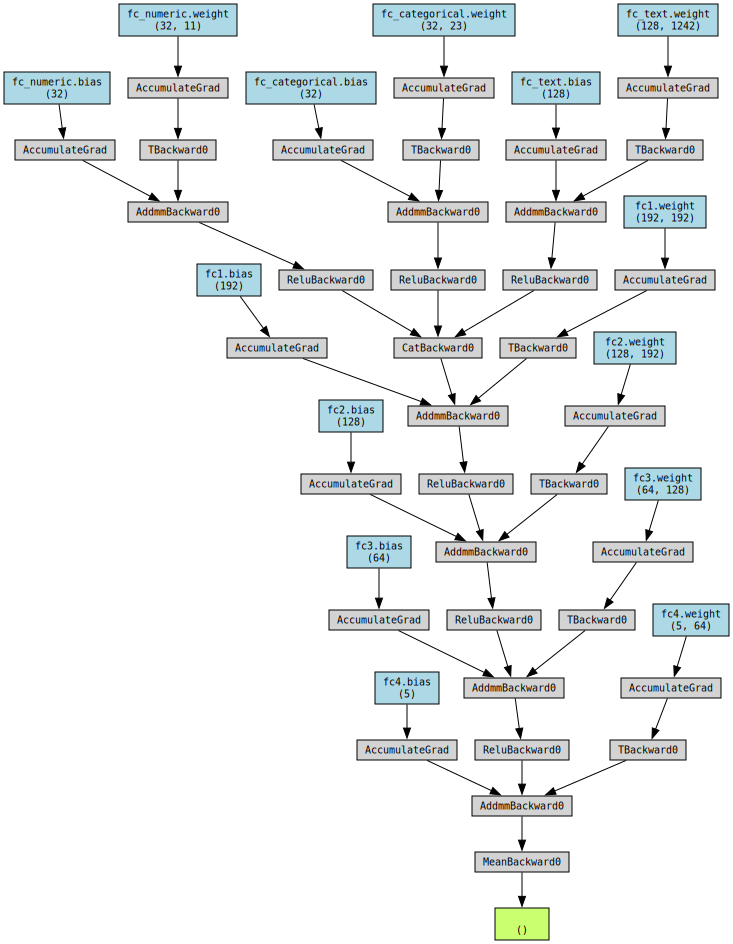

In [15]:
from torchviz import make_dot
m = model(X_numeric_test, X_categorical_test, X_text_test)
make_dot(m.mean(), params=dict(model.named_parameters()))